In [51]:
#All liberies
from numba import njit
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import lil_matrix
from tqdm import tqdm
from pympler import asizeof
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix

In [17]:
def rotate_vec(vector, n):
    rotation_matrices = {
        0: np.array([[1, 0], [0, 1]]),    # 0 degrees
        1: np.array([[0, -1], [1, 0]]),   # 90 degrees
        2: np.array([[-1, 0], [0, -1]]),  # 180 degrees
        3: np.array([[0, 1], [-1, 0]])    # 270 degrees
    }
    
    roated_vector = rotation_matrices[n] @ vector
    return roated_vector


def segment_point(p1,p2):
    v1 = np.array(np.array(p2)-np.array(p1))
    relative_length = np.linalg.norm(v1)/4
    v1 = v1/np.linalg.norm(v1)
    v2 = np.array([0.0,1.0])
    angle = np.arctan2(v1[1], v1[0])
    angle_degrees = np.degrees(angle)
    angle_degrees = angle_degrees % 360
    n = round(angle_degrees / 90) % 4
    vectors_list = [[relative_length, 0.0], 
                    [0.0, relative_length], 
                    [relative_length, 0.0], 
                    [0.0, -relative_length], 
                    [0.0, -relative_length], 
                    [relative_length, 0.0], 
                    [0.0, relative_length]]
    point = np.array(p1)
    points_list = [p1]
    for vectors in vectors_list:
        roatated_vec = rotate_vec(vectors,n)
        point = point + roatated_vec
        points_list.append(np.round(point).tolist())
    return points_list

def new_line(line):
    new_line = []
    for i in range(0,len(line)-1):
        segment_points = segment_point(line[i], line[i+1]) 
        new_line = new_line + segment_points
    new_line.append(line[-1])
    return new_line

def fract(l, line):
    for _i in range(0,l):
        line = new_line(line)
    return line

def plotting_line(l, size):
    line = [[0.0,0.0], [size,0.0]]
    for i in range(0,l+1):
        line = fract(i,line)
        x_cords = [i[0] for i in line]
        y_cords = [i[1] for i in line]
        plt.plot(x_cords,y_cords)
    plt.show()

def plotting_square(l,size):
    for i in range(0,l+1):
        total_points = generate_square_without_shift(i, size)
        x_cords = [i[0] for i in total_points]
        y_cords = [i[1] for i in total_points]
        plt.plot(x_cords,y_cords)
    plt.show()


def generate_square_without_shift(l,size):
    lines = [
        [[0.0, 0.0], [size, 0.0]],  
        [[size, 0.0], [size, size]],
        [[size, size], [0.0, size]],
        [[0.0, size], [0.0, 0.0]]
        ]
    total_points = []
    for line in lines:
        line = fract(l,line)
        total_points = total_points + line
    min_x = min([i[0] for i in total_points])
    min_y = min([i[1] for i in total_points])
    print(min_x,min_y)
    total_points = [i + [min_x,min_y] for i in total_points]
    return total_points

    
def generate_square(l, size):
    lines = [
        [[0.0, 0.0], [size, 0.0]],  
        [[size, 0.0], [size, size]],
        [[size, size], [0.0, size]],
        [[0.0, size], [0.0, 0.0]]
    ]
    
    total_points = []
    
    for line in lines:
        line_points = fract(l, line)  
        total_points.extend(line_points)  

    min_x = min(point[0] for point in total_points)
    min_y = min(point[1] for point in total_points)

    adjusted_points = [[point[0] - min_x, point[1] - min_y] for point in total_points]
    return adjusted_points


0.0 0.0
-16.0 -16.0
-20.0 -20.0
-21.0 -21.0


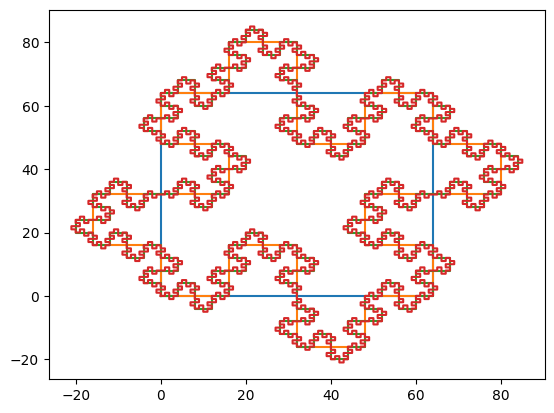

In [18]:
plotting_square(3,4**3)

In [ ]:
def does_intersect(x1,x2,point):
    if x1[1] > x2[1]:
        x1, x2 = x2, x1
        
    if x1[1] <= point[1] < x2[1]: 
        x_intersect = (point[1] + 0.001 - x1[1]) * (x2[0] - x1[0]) / (x2[1] - x1[1]) + x1[0]
        return x_intersect > point[0] 
    return False



def in_boundry(point,boundry): 
    boundry = np.array(boundry)   
    n = len(boundry)
    num_of_intersect = 0
    for i in range(n):
        p1 = boundry[i]
        p2 = boundry[(i+1)%n]
        if does_intersect(p1,p2, point) :
            num_of_intersect +=1
    return num_of_intersect % 2 == 1

def in_boundry_vecotrized(points, boundry):
    boundry = np.array(boundry)
    n = len(boundry)
    num_of_intersect = np.zeros(len(points), dtype=int)

    for i in range(n):
        p1 = boundry[i]
        p2 = boundry[(i + 1) % n]
        intersects = np.array([does_intersect(p1, p2, point) for point in points])
        num_of_intersect += intersects

    return num_of_intersect % 2 == 1

In [20]:
def generate_grid(l):
    size = 4**l
    if l < 3:
        size = 4**3
    boundry = generate_square(l, size)
    x_boundry = [i[0] for i in boundry]
    y_boundry = [i[1] for i in boundry]
    min_x = int(min(x_boundry))
    max_x = int(max(x_boundry))
    min_y = int(min(y_boundry))
    max_y = int(max(y_boundry))
    grid_x = [i for i in range(min_x,max_x)]
    grid_y = [i for i in range(min_y,max_y)]
    grid = np.array([[grid_x[j], grid_y[i]] for i in range(len(grid_y)) for j in range(len(grid_x))])
    return grid, boundry

In [54]:
def discrete_laplacian(vector_length, row_length):
    total_array = []
    for i in range(vector_length):
        new_array = np.zeros(vector_length)
        
        next_x = i + 1
        next_y = i + row_length
        previous_x = i - 1
        previous_y = i - row_length
        
        if next_x < vector_length and (i % row_length) < (row_length - 1):
            new_array[next_x] = -1
        if next_y < vector_length and (i // row_length) < (row_length - 1):
            new_array[next_y] = -1
        if previous_x >= 0 and (i % row_length) > 0:  
            new_array[previous_x] = -1
        if previous_y >= 0 and (i // row_length) > 0: 
            new_array[previous_y] = -1
        
        new_array[i] = 4 
        total_array.append(new_array)
    
    return np.array(total_array), row_length

def system_laplacian(vector_length, row_length, boundry):
    laplacian_matrix = discrete_laplacian(vector_length, row_length)[0]
    points_list = []
    points_outside = []
    for i in range(0,vector_length):
        point = [i % row_length, i // row_length]
        points_list.append(point)
        if not in_boundry(point, boundry):
            laplacian_matrix[i] = np.zeros(vector_length)
            points_outside.append(point)
    return laplacian_matrix, points_outside, points_list


def sparse_discrete_laplacian(vector_length, row_length, boundry):
    laplacian_matrix = lil_matrix((vector_length, vector_length))

    for i in range(vector_length):
        if in_boundry([i % row_length, i // row_length], boundry):
            next_x = i + 1
            next_y = i + row_length
            previous_x = i - 1
            previous_y = i - row_length

            if next_x < vector_length and (i % row_length) < (row_length - 1):
                laplacian_matrix[i, next_x] = -1
            if next_y < vector_length and (i // row_length) < (row_length - 1):
                laplacian_matrix[i, next_y] = -1
            if previous_x >= 0 and (i % row_length) > 0:
                laplacian_matrix[i, previous_x] = -1
            if previous_y >= 0 and (i // row_length) > 0:
                laplacian_matrix[i, previous_y] = -1

            laplacian_matrix[i, i] = 4

    return laplacian_matrix, row_length

def sparse_system_laplacian_2(vector_length, row_length, boundry):
    laplacian_matrix, _ = sparse_discrete_laplacian(vector_length, row_length)
    points_list = np.empty((vector_length, 2))

    for i in (range(vector_length)):
        point = [i % row_length, i // row_length]
        points_list[i] = point
        if not in_boundry(point, boundry):
            laplacian_matrix[i] = 0

    return laplacian_matrix, points_list


def sparse_system_laplacian(vector_length, row_length, boundry):
    laplacian_matrix = sparse_discrete_laplacian(vector_length, row_length)[0]
    print("Donw with generating the laplace matrix")
    points_list = np.array([[i % row_length, i // row_length] for i in range(vector_length)])
    
    mask_outside = ~in_boundry_vecotrized(points_list, boundry)
    
    print("Applying boundry conditions")
    laplacian_matrix[mask_outside, :] = 0
    
    points_outside = points_list[mask_outside].tolist()
    
    return laplacian_matrix, points_outside, points_list.tolist()

$dd = \frac{U_{n-1,m} + U_{n+1,m} + U_{n,m-1} + U_{n,m-1} - 4U_{n,m}}{h^2} $ 

In [55]:
def find_ram_procentage():
    total_ram = 15.7*10**9
    max_size_of_l = 3
    grid, boundry = generate_grid(max_size_of_l)
    print("Done with genereating grid")
    x_collum = [i[0] for i in grid]
    y_collum = [i[1] for i in grid]
    laplician  = sparse_discrete_laplacian(len(grid),max(x_collum)+1, boundry)

    procent_of_ram = asizeof.asizeof(laplician) / total_ram * 100
    print(procent_of_ram, "%") 

find_ram_procentage()

Done with genereating grid
0.0011515414012738853 %


In [23]:
#x_points = [points[0] for points in points_outside]
#y_points = [points[1] for points in points_outside]
#plt.scatter(x_points,y_points)

In [24]:
def find_eiegenvalues(laplacian):
    eigenvalues, eigenvectors = eigsh(laplacian, k=300, which='SM')
    print("E-value: ", eigenvalues)
    return eigenvalues, eigenvectors

In [25]:
def plotting_eigenvectors(eigenvectors,boundry):
    x_boundry = [i[0] for i in boundry]
    y_boundry = [i[1] for i in boundry]


    max_dim = int(np.sqrt(len(eigenvectors[:,0])))

    for i in range(0,10):
        vibrations = eigenvectors[:, i].reshape(max_dim,max_dim)
        plt.imshow(vibrations, extent=(0, max_dim, 0, max_dim), origin='lower', cmap='viridis', aspect='auto')
        plt.plot(x_boundry,y_boundry, color="r")
        plt.show()


100%|██████████| 11236/11236 [00:22<00:00, 492.97it/s]


E-value:  [0.01934741 0.04086374 0.04086374 0.0423333  0.04313214 0.04952054
 0.04952054 0.06685732 0.07570111 0.07995859 0.07995859 0.08522341
 0.09086189 0.09933058 0.10027341 0.10027341 0.11698933 0.1198309
 0.13070752 0.13070752 0.13885861 0.13944699 0.14768291 0.14768291
 0.16508124 0.16508124 0.16508282 0.1651003  0.1682667  0.1682667
 0.17142397 0.18030363 0.19457806 0.20771695 0.20771695 0.21092879
 0.21181739 0.21181739 0.21516929 0.22015156 0.22912497 0.23841472
 0.23841472 0.24355904 0.2461445  0.25149429 0.25149429 0.26074045
 0.26717006 0.2739428  0.27501958 0.27501958 0.27635338 0.28779183
 0.28893347 0.28986689 0.28986689 0.30188292 0.30188292 0.30458003
 0.30807064 0.31493822 0.32026151 0.32026151 0.33376072 0.33906371
 0.33906371 0.34169517 0.34767061 0.35780832 0.36059023 0.36059023
 0.36729481 0.37072359 0.37072359 0.37712107 0.38209603 0.39402037
 0.39402037 0.39471027 0.39958519 0.39958519 0.40361887 0.41133369
 0.41769119 0.41769119 0.42272188 0.43037741 0.4327001

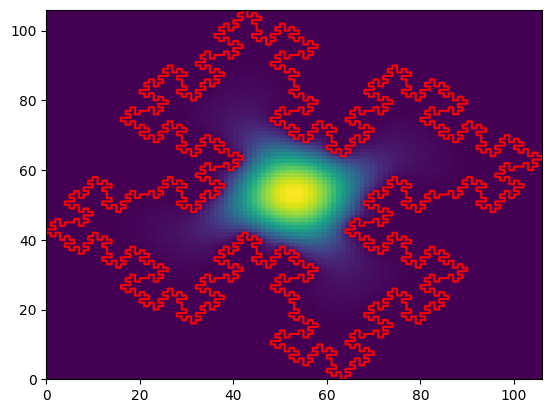

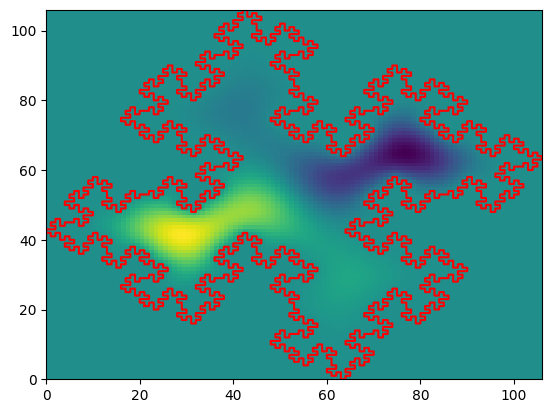

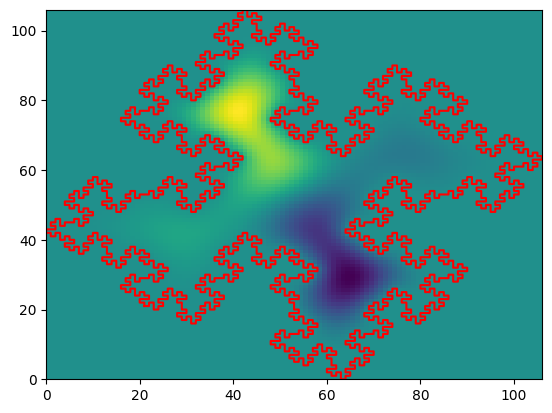

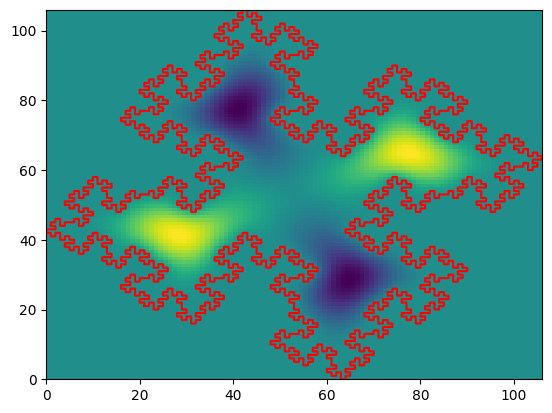

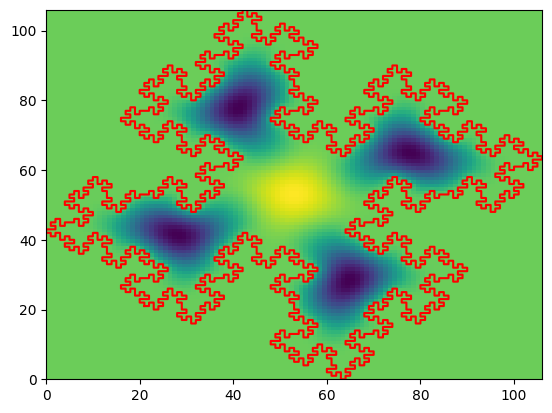

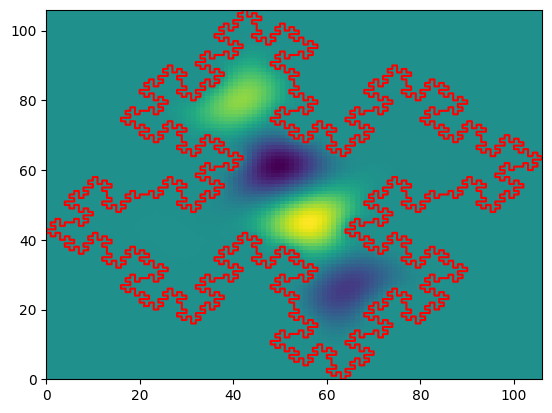

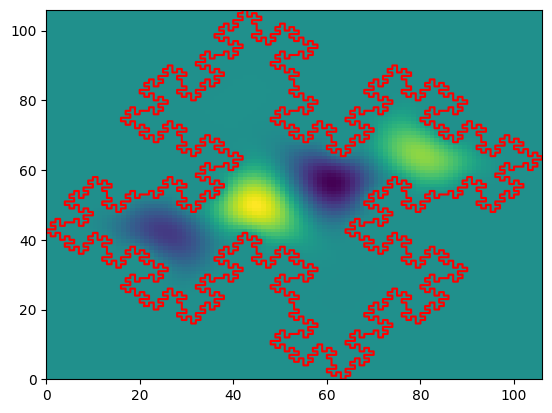

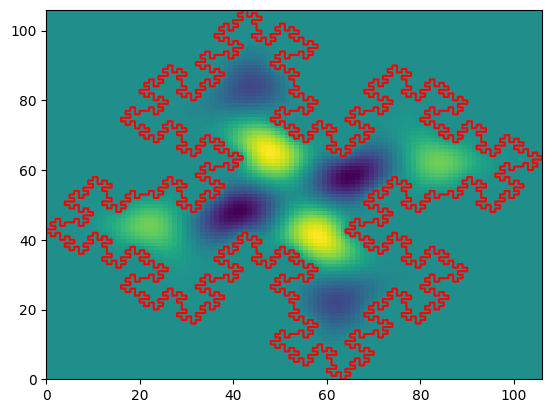

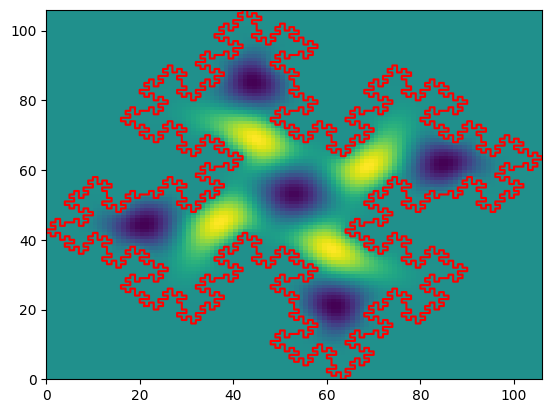

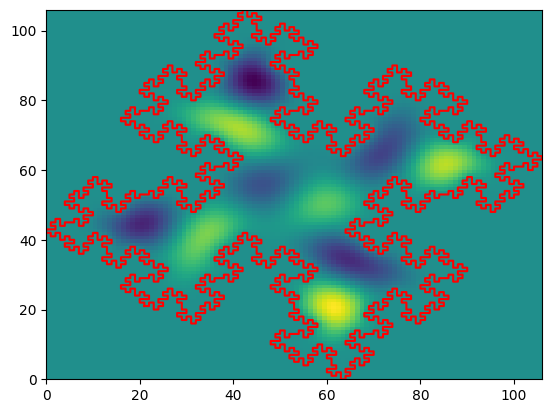

In [27]:
grid, boundry =generate_grid(3)
x_collum = grid[:,0]
lapliacian, _, _  = sparse_system_laplacian_2(len(grid),max(x_collum)+1, boundry)
eigenvalues, eigenvectors = find_eiegenvalues(lapliacian)
plotting_eigenvectors(eigenvectors,boundry)

In [31]:
def finding_d(eigenvalues):
    eigenvalues_set = np.array(list(set(eigenvalues)))
    eigenvalues_set.sort()
    log_eigenvalues = [np.log(i) for i in eigenvalues_set][10:]
    x_axis  = [np.log(i) for i in range(1, len(eigenvalues_set)+1)][10:]
    plt.plot(x_axis, log_eigenvalues)
    coefficients = np.polyfit(x_axis, log_eigenvalues, 1)
    f_x = lambda x: coefficients[0]*x+coefficients[1]
    v_f_x = np.vectorize(f_x)
    plt.plot ( x_axis, v_f_x(x_axis))
    plt.show()
    scalar = 1/coefficients[0]
    print("Scaling of deltaN: ", scalar)
    return scalar

Donw with generating the laplace matrix
Applying boundry conditions
E-value:  [0.01467939 0.02699272 0.02699272 0.0283566  0.03031807 0.03935614
 0.03935614 0.04916477 0.05239657 0.053327   0.053327   0.055039
 0.0595609  0.06527875 0.06527875 0.07239447 0.07760968 0.08165333
 0.08572556 0.08572556 0.09994589 0.10193201 0.1046185  0.1046185
 0.10743535 0.10877253 0.11529756 0.11529756 0.1329355  0.1329355
 0.13310147 0.13779559 0.14157126 0.14319531 0.14319531 0.14500606
 0.14939428 0.15490307 0.15490307 0.15847877 0.15885685 0.16661032
 0.16736378 0.16736378 0.17262727 0.17262727 0.17541888 0.17967419
 0.18005138 0.18540259 0.18540259 0.18560049 0.19501345 0.20436758
 0.20436758 0.2105488  0.21217719 0.22008935 0.22008935 0.2292324
 0.23104999 0.23304883 0.23304883 0.23690795 0.2404438  0.24982934
 0.24982934 0.24989107 0.25193601 0.25337256 0.2543794  0.26043866
 0.26043866 0.26813576 0.26813576 0.28106069 0.28713827 0.28917898
 0.29503287 0.29503287 0.30015133 0.30015133 0.30259648 

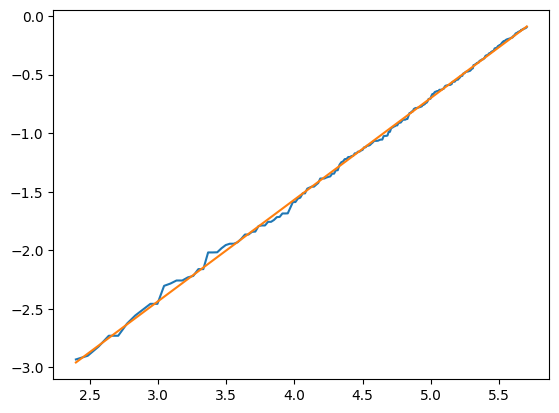

Scaling of deltaN:  1.1525935836676542
Scaling for l=1: 1.1525935836676542
Donw with generating the laplace matrix
Applying boundry conditions
E-value:  [0.01813223 0.03709109 0.03709109 0.03846446 0.03942782 0.04669402
 0.04669402 0.06256502 0.07025464 0.07395322 0.07395322 0.07893019
 0.08458053 0.09325134 0.09355703 0.09355703 0.10908151 0.11168293
 0.1205423  0.1205423  0.12903996 0.12979112 0.13925736 0.13925736
 0.14955444 0.14956026 0.14956667 0.14956667 0.15871354 0.15871354
 0.16278279 0.17213014 0.18054862 0.1918892  0.1918892  0.19272584
 0.19839167 0.19839167 0.1988567  0.20554608 0.21254351 0.22137321
 0.22137321 0.22561809 0.22659924 0.2310743  0.2310743  0.24444024
 0.24711375 0.25103929 0.2526496  0.2526496  0.25474373 0.26411307
 0.26530991 0.26530991 0.26580893 0.27326367 0.27326367 0.27382231
 0.27549716 0.28702844 0.29526293 0.29526293 0.3074729  0.31475553
 0.31475553 0.32367926 0.32639599 0.3267619  0.32755485 0.32755485
 0.33106793 0.33396906 0.33396906 0.3343491

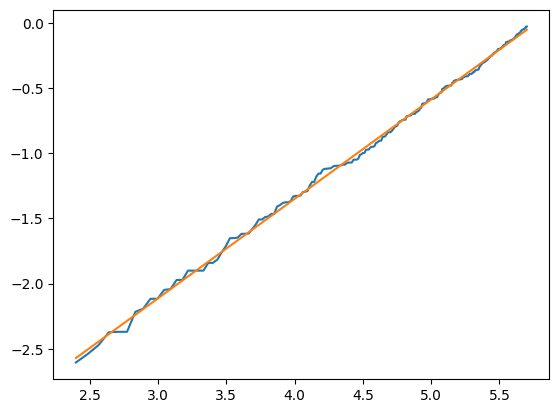

Scaling of deltaN:  1.3117649828637354
Scaling for l=2: 1.3117649828637354
Donw with generating the laplace matrix
Applying boundry conditions
E-value:  [0.01934741 0.04086374 0.04086374 0.0423333  0.04313214 0.04952054
 0.04952054 0.06685732 0.07570111 0.07995859 0.07995859 0.08522341
 0.09086189 0.09933058 0.10027341 0.10027341 0.11698933 0.1198309
 0.13070752 0.13070752 0.13885861 0.13944699 0.14768291 0.14768291
 0.16508124 0.16508124 0.16508282 0.1651003  0.1682667  0.1682667
 0.17142397 0.18030363 0.19457806 0.20771695 0.20771695 0.21092879
 0.21181739 0.21181739 0.21516929 0.22015156 0.22912497 0.23841472
 0.23841472 0.24355904 0.2461445  0.25149429 0.25149429 0.26074045
 0.26717006 0.2739428  0.27501958 0.27501958 0.27635338 0.28779183
 0.28893347 0.28986689 0.28986689 0.30188292 0.30188292 0.30458003
 0.30807064 0.31493822 0.32026151 0.32026151 0.33376072 0.33906371
 0.33906371 0.34169517 0.34767061 0.35780832 0.36059023 0.36059023
 0.36729481 0.37072359 0.37072359 0.37712107 

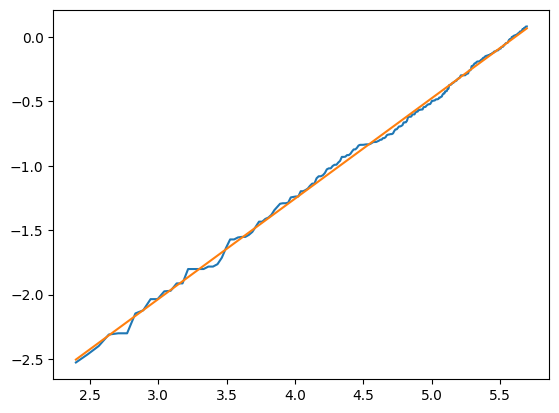

Scaling of deltaN:  1.2839506794906217
Scaling for l=3: 1.2839506794906217


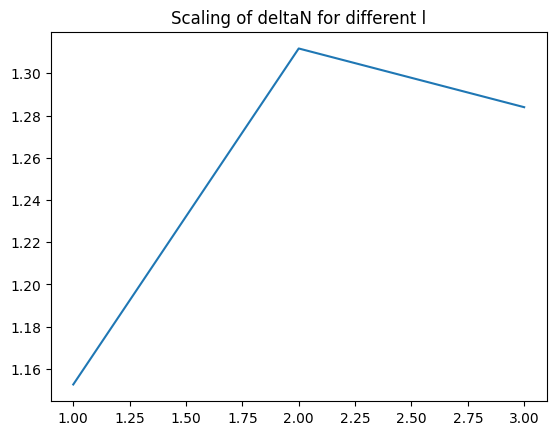

{1: np.float64(1.1525935836676542), 2: np.float64(1.3117649828637354), 3: np.float64(1.2839506794906217)}


In [32]:
def find_scaling_for_different_l(l_values):
    scalings = {}
    for l in l_values:
        grid, boundry = generate_grid(l)
        x_collum = [i[0] for i in grid]
        laplacian, points_outside, points = sparse_system_laplacian(len(grid), max(x_collum) + 1, boundry)
        eigenvalues, _ = find_eiegenvalues(laplacian)
        scaling = finding_d(eigenvalues)
        scalings[l] = scaling
        print(f"Scaling for l={l}: {scaling}")
    
    plt.plot(l_values,scalings.values())
    plt.title("Scaling of deltaN for different l")
    plt.show()
    return scalings

# Example usage:
l_values = [1, 2, 3, 4]
scalings = find_scaling_for_different_l(l_values)
print(scalings)